In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

/home/felipe/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

A primeira coisa que vamos fazer é ler o conjunto de dados usando a função read_csv() dos Pandas. 
Colocaremos esses dados em um DataFrame do Pandas, chamado "titanic", e nomearemos cada uma das colunas.

In [3]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


VARIABLE DESCRIPTIONS
Survived - Survival (0 = No; 1 = Yes);
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd);
Name - Name;
Sex - Sex;
Age - Age;
SibSp - Number of Siblings/Spouses Aboard;
Parch - Number of Parents/Children Aboard;
Ticket - Ticket Number;
Fare - Passenger Fare (British pound);
Cabin - Cabin;
Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton);

Como estamos construindo um modelo para prever a sobrevivência de passageiros do Titanic, nosso alvo será a variável "Survived" do dataframe titanic.
Para ter certeza de que é uma variável binária, vamos usar a função countplot () do Seaborn.

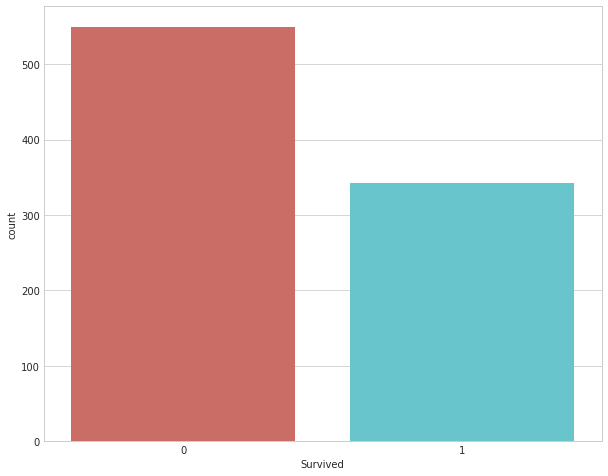

In [4]:
sb.countplot(x='Survived',data=titanic, palette='hls')

Ok, agora veja que a variavel Survived é binária

# Checking for missing values
É fácil checar missing values usando método isnull() com o método sum(), o número retornado condiz com a quantidade True para o teste, ou seja, quantidade de valores nulos nas variaveis

In [5]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
titanic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Ok, então existem 891 linhas no dataframe. Cabin é quase todo composto por missing values, então podemos eliminar essa variável completamente! Mas e quanto à idade? A age parece um preditor relevante para a sobrevivência, certo? Nós queremos manter as variáveis, mas tem 177 missing values. Precisamos encontrar uma maneira de nos aproximarmos desses valores em falta!

# Lidando com missing values
Removendo missing values
Vamos além dos missing values... Vamos descartar todas as variáveis que não são relevantes para a predição de Survived.

In [7]:
#E quanto ao nome de uma pessoa, número do bilhete e número de identificação do passageiro? Eles são irrelavantes para prever a capacidade de sobrevivência. E, como você se lembra, a variável cabine é quase todoa com missing values!!
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Agora, o dataframe foi reduzido para apenas variáveis relevantes, mas agora precisamos lidar com os valores ausentes na variável age.

# Imputing missing values
Vejamos como a idade do passageiro está relacionada à sua classe como passageiro no barco.

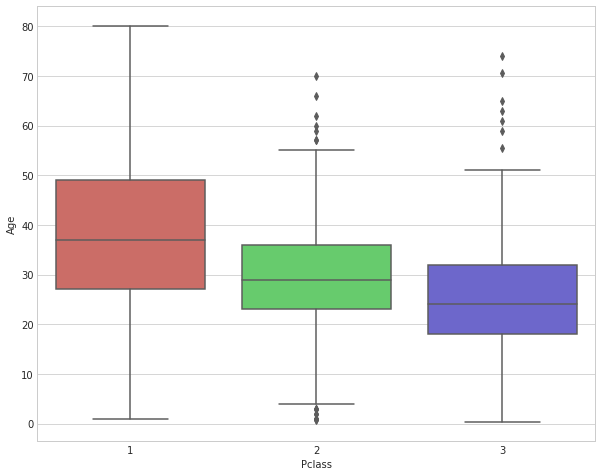

In [8]:
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

Falando mais ou menos, poderíamos dizer que quanto mais jovem é um passageiro, mais provável é que ele esteja na 3ª classe. Quanto mais velho for um passageiro, maior a probabilidade de estarem na 1ª classe. Portanto, há um relacionamento frouxo entre essas variáveis. Então, vamos escrever uma função que se aproxime da idade dos passageiros, com base em sua classe. Na caixa, parece que a idade média dos passageiros de 1ª classe é de cerca de 37 anos, os passageiros de 2ª classe são 29 e os passageiros de 3ª classe são 24.

Então, vamos escrever uma função que encontre cada valor nulo na variável Age e, para cada nulo, verifique o valor da Pclass e atribua um valor de idade de acordo com a idade média dos passageiros nessa classe.

In [9]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Após definir a função, vamos executar apenas para os valores nulos de Age

In [10]:
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)

In [11]:
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

Existem ainda 2 valores nulos na variável Embarked. Podemos eliminar esses dois registros sem perder muitas informações importantes do nosso conjunto de dados, então faremos isso.

In [12]:
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# Converting categorical variables to a dummy indicators

In [13]:
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [14]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [15]:
#Ainda não alteramos os dados! Vamos alterar em seguida.
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [16]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [17]:
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Agora temos um conjunto de dados com todas as variáveis no formato correto!

# Validando independencia entre as variáveis

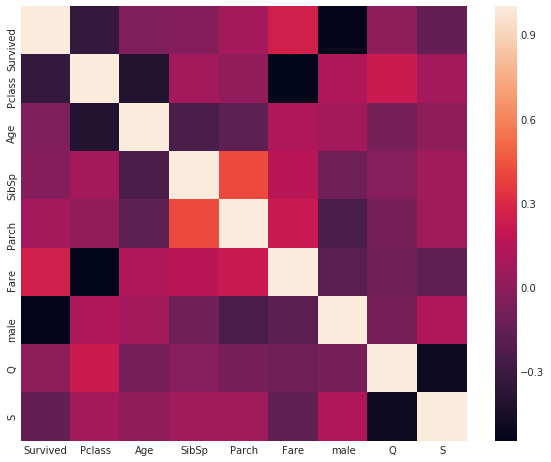

In [18]:
sb.heatmap(titanic_dmy.corr())

Fare e Pclass não sao independentes uma com a outra, entao vou excluí-las.

In [19]:
titanic_dmy.drop(['Pclass', 'Fare'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,male,Q,S
0,0,22.0,1,0,1,0,1
1,1,38.0,1,0,0,0,0
2,1,26.0,0,0,0,0,1
3,1,35.0,1,0,0,0,1
4,0,35.0,0,0,1,0,1


# Agora vamos lá!!
1º: Separar o conjunto em variavel resposta e variaveis de treinamento

In [22]:
X = titanic_dmy.iloc[:,[1,2,3,4,5,6]].values
y = titanic_dmy.iloc[:,0].values

Agora dividir em treino e teste (teste com 30%)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

# Criando o modelo

In [24]:
Classif_RL = LogisticRegression()
Classif_RL.fit(X_train, y_train)
y_pred = Classif_RL.predict(X_train)

print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.87      0.84       385
          1       0.76      0.68      0.72       237

avg / total       0.80      0.80      0.80       622



In [26]:
Classif_Tree = DecisionTreeClassifier()
Classif_Tree.fit(X_train, y_train)
y_pred = Classif_Tree.predict(X_train)

print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.90      0.99      0.94       385
          1       0.97      0.82      0.89       237

avg / total       0.93      0.92      0.92       622



In [27]:
Classif_KNN = KNeighborsClassifier(9)
Classif_KNN.fit(X_train, y_train)
y_pred = Classif_KNN.predict(X_train)

print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.77      0.92      0.84       385
          1       0.81      0.56      0.66       237

avg / total       0.79      0.78      0.77       622



In [28]:
Classif_NAIVE = GaussianNB()
Classif_NAIVE.fit(X_train, y_train)
y_pred = Classif_NAIVE.predict(X_train)

print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.89      0.85       385
          1       0.78      0.67      0.72       237

avg / total       0.80      0.80      0.80       622



In [30]:
Classif_SVM = SVC(C=15, gamma=0.01)
Classif_SVM.fit(X_train, y_train)
y_pred = Classif_SVM.predict(X_train)

print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.88      0.86       385
          1       0.79      0.73      0.76       237

avg / total       0.82      0.82      0.82       622

